In [45]:
pip install optuna

In [46]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

In [47]:
df = pd.read_csv('BNB-USD.csv')

In [48]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [49]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [51]:
# Hàm tạo đặc trưng lag
def create_lagged_features(data, n_lags=1):
    df_lags = pd.DataFrame()
    for i in range(n_lags):
        df_lags[f'lag_{i+1}'] = np.roll(data, shift=i+1)
    df_lags['target'] = data
    return df_lags.iloc[n_lags:]

In [52]:
# Hàm tối ưu hóa sử dụng Optuna
def objective(trial):
    # Gợi ý giá trị cho n_lags và n_estimators
    n_lags = trial.suggest_int('n_lags', 1, 30)                 # Tìm số lượng lag từ 1 đến 30
    n_estimators = trial.suggest_int('n_estimators', 10, 200)   # Tìm số lượng cây từ 10 đến 200

    # Tạo đặc trưng lag
    lagged_data = create_lagged_features(data_scaled.flatten(), n_lags)
    X, y = lagged_data.iloc[:, :-1], lagged_data.iloc[:, -1]

    tscv = TimeSeriesSplit(n_splits=5)
    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        errors.append(mean_squared_error(y_test, y_pred))

    return np.mean(errors)

**Tìm kiếm tham số tối ưu**

In [53]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần để tìm giá trị tối ưu

# In ra tham số tối ưu
best_params = study.best_params
print(f'Best parameters: {best_params}')
print(f'Best trial value: {study.best_value}')


[I 2024-06-13 02:52:35,914] A new study created in memory with name: no-name-e226aabe-e1ae-4e5a-94ed-3c1fe49b40e8
[I 2024-06-13 02:52:41,283] Trial 0 finished with value: 0.04599166831963046 and parameters: {'n_lags': 2, 'n_estimators': 84}. Best is trial 0 with value: 0.04599166831963046.
[I 2024-06-13 02:52:43,208] Trial 1 finished with value: 0.04601511391151254 and parameters: {'n_lags': 1, 'n_estimators': 77}. Best is trial 0 with value: 0.04599166831963046.
[I 2024-06-13 02:52:47,770] Trial 2 finished with value: 0.04614635120706526 and parameters: {'n_lags': 5, 'n_estimators': 186}. Best is trial 0 with value: 0.04599166831963046.
[I 2024-06-13 02:52:49,167] Trial 3 finished with value: 0.047217709046959815 and parameters: {'n_lags': 8, 'n_estimators': 41}. Best is trial 0 with value: 0.04599166831963046.
[I 2024-06-13 02:53:00,050] Trial 4 finished with value: 0.048212754758010304 and parameters: {'n_lags': 16, 'n_estimators': 176}. Best is trial 0 with value: 0.045991668319630

Best parameters: {'n_lags': 3, 'n_estimators': 171}
Best trial value: 0.045980425083672616


**Sử dụng tham số tối ưu để huấn luyện mô hình cuối cùng**

In [54]:
optimal_n_lags = best_params['n_lags']
optimal_n_estimators = best_params['n_estimators']
lagged_data = create_lagged_features(data_scaled.flatten(), optimal_n_lags)

In [55]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(0.8 * len(lagged_data))
train_data, test_data = lagged_data[:train_size], lagged_data[train_size:]
# Tách các đặc trưng và mục tiêu
X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

In [56]:
# Huấn luyện mô hình Random Forest với các tham số tối ưu
rf_model = RandomForestRegressor(n_estimators=optimal_n_estimators, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=171, random_state=42)

In [57]:
# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

In [58]:
# Chuyển đổi lại dữ liệu về thang đo gốc
y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [59]:
# Tính toán các độ đo lỗi
test_mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)
test_mse = mean_squared_error(y_test_inverse, y_pred_inverse)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape:.4f}")
print(f"RMSE on Test dataset: {test_rmse:.4f}")
print(f"MSE on Test dataset: {test_mse:.4f}")

MAPE on Test dataset: 0.0251
RMSE on Test dataset: 13.5896
MSE on Test dataset: 184.6778


In [60]:
# Hàm dự báo tương lai
def forecast_future(model, data, n_lags, n_periods):
    future_forecast = []
    last_values = data[-n_lags:]
    for _ in range(n_periods):
        prediction = model.predict(last_values.reshape(1, -1))[0]
        future_forecast.append(prediction)
        last_values = np.append(last_values[1:], prediction)
    return np.array(future_forecast)

In [61]:
# Dự báo giá trị tương lai
forecast_30_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 30)
forecast_60_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 60)
forecast_90_days = forecast_future(rf_model, data_scaled.flatten(), optimal_n_lags, 90)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

In [62]:
# Chuyển đổi dự báo về thang đo gốc
forecast_30_days_inverse = scaler.inverse_transform(forecast_30_days.reshape(-1, 1))
forecast_60_days_inverse = scaler.inverse_transform(forecast_60_days.reshape(-1, 1))
forecast_90_days_inverse = scaler.inverse_transform(forecast_90_days.reshape(-1, 1))

In [64]:
print('Predicted closing prices for the next 30 days:')
print(forecast_30_days_inverse.flatten())

print('Predicted closing prices for the next 60 days:')
print(forecast_60_days_inverse.flatten())

print('Predicted closing prices for the next 90 days:')
print(forecast_90_days_inverse.flatten())

Predicted closing prices for the next 30 days:
[577.72663146 580.70418046 590.08099464 580.21128666 584.7746258
 582.00390804 593.77996358 589.68996856 583.99267264 578.03907112
 589.69181768 586.50553963 568.71388763 594.92037574 585.37873711
 564.62256041 599.55760742 569.15934734 566.35139139 603.48293992
 556.72384548 573.79805216 586.71987567 581.80397488 583.64903253
 582.5015066  594.7368528  590.59841224 584.75554071 578.21056816]
Predicted closing prices for the next 60 days:
[577.72663146 580.70418046 590.08099464 580.21128666 584.7746258
 582.00390804 593.77996358 589.68996856 583.99267264 578.03907112
 589.69181768 586.50553963 568.71388763 594.92037574 585.37873711
 564.62256041 599.55760742 569.15934734 566.35139139 603.48293992
 556.72384548 573.79805216 586.71987567 581.80397488 583.64903253
 582.5015066  594.7368528  590.59841224 584.75554071 578.21056816
 589.81786923 586.63481244 568.7239977  595.11321542 585.37873711
 563.80594071 600.49831266 569.04466585 566.67701

In [65]:
# Tạo index cho các dự đoán tiếp theo
last_date = df.index[-1]
index_next_30_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=30, freq='D')
index_next_60_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=60, freq='D')
index_next_90_days = pd.date_range(last_date + pd.Timedelta(days=1), periods=90, freq='D')

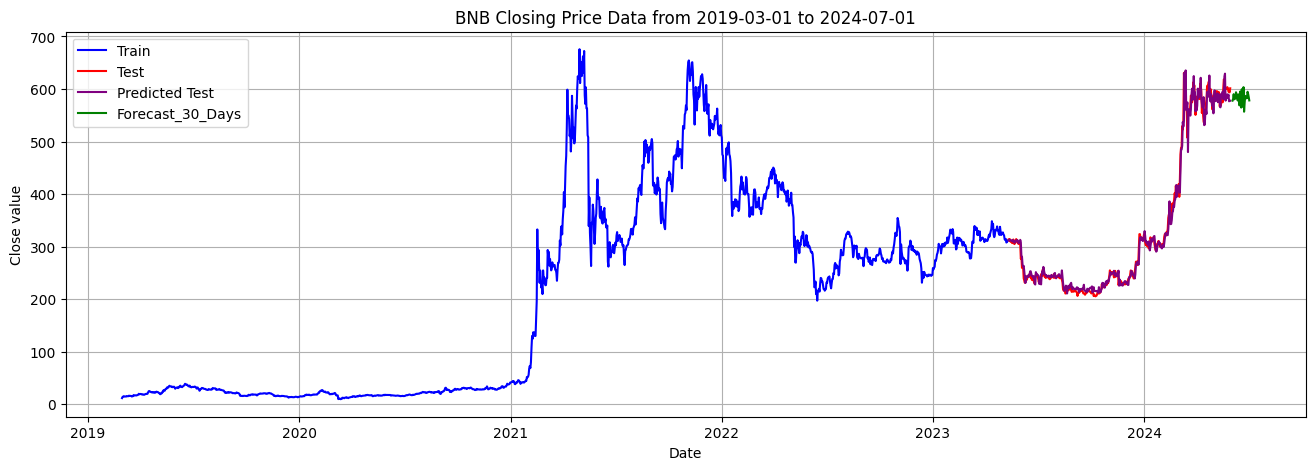

In [66]:
# Vẽ đồ thị cho dự đoán 30 ngày
plt.figure(figsize=(16, 5)),
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='Predicted Test')
plt.plot(index_next_30_days, forecast_30_days_inverse, color='green', linestyle='-', label='Forecast_30_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RandomForest_BNB_30days_82.png')
plt.show()


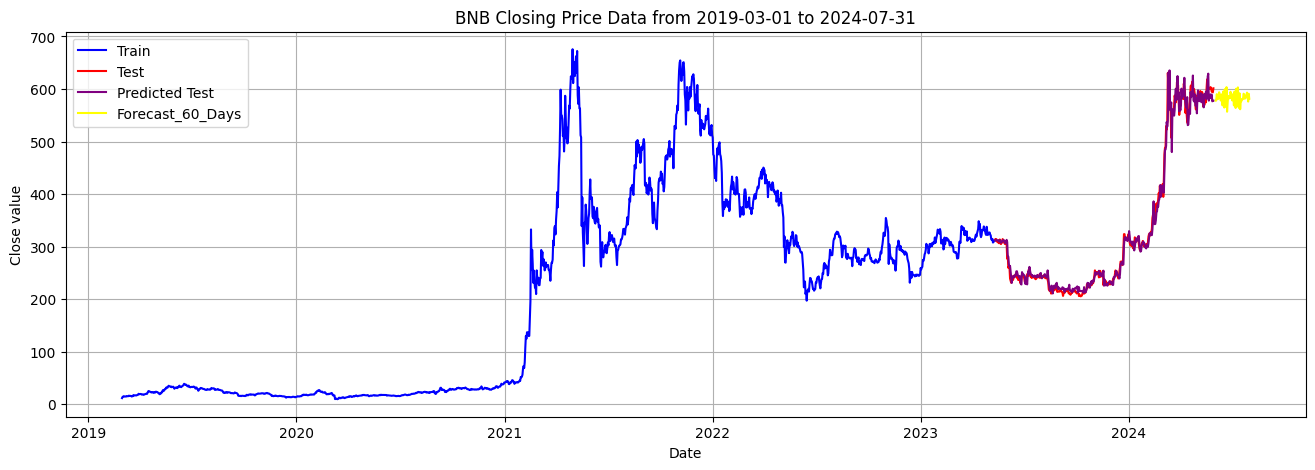

In [67]:
# Vẽ đồ thị cho dự đoán 60 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='Predicted Test')
plt.plot(index_next_60_days, forecast_60_days_inverse, color='yellow', linestyle='-', label='Forecast_60_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RandomForest_BNB_60days_82.png')
plt.show()


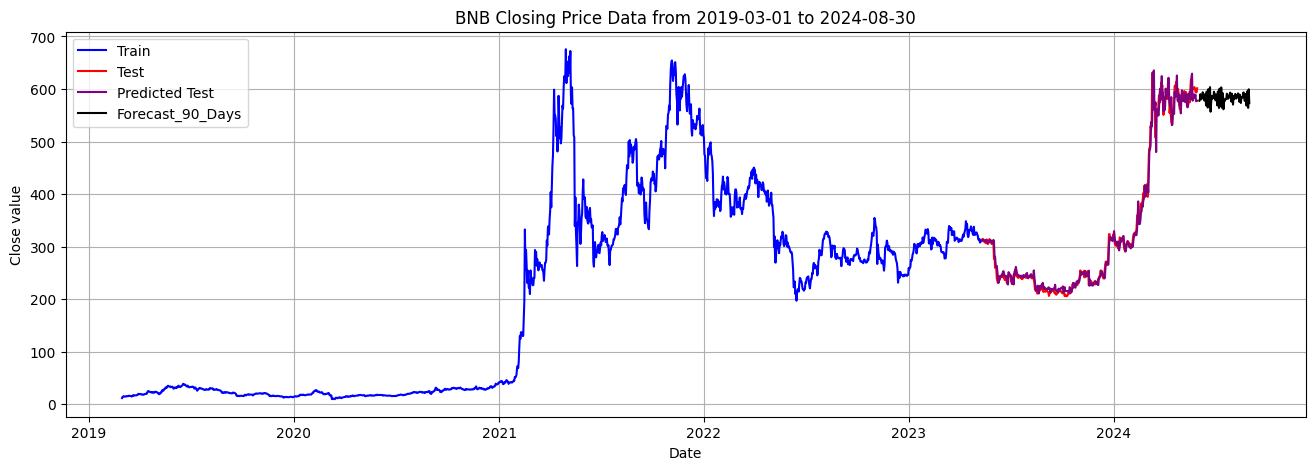

In [68]:
# Vẽ đồ thị cho dự đoán 90 ngày
plt.figure(figsize=(16, 5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data['target'].values.reshape(-1, 1)),
         color='blue', linestyle='-', label='Train')
plt.plot(df.index[train_size:train_size + len(y_test)], y_test_inverse, color='red', linestyle='-', label='Test')
plt.plot(df.index[train_size:train_size + len(y_test)], y_pred_inverse, color='purple', linestyle='-', label='Predicted Test')
plt.plot(index_next_90_days, forecast_90_days_inverse, color='black', linestyle='-', label='Forecast_90_Days')
plt.legend()
plt.grid()
plt.title(f"BNB Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('RandomForest_BNB_90days_82.png')
plt.show()